Batch: DS C43
Members: Pandiarajan Nammalwar, Poornima Konanur, Niraj Kumar

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [105]:
#Data file is close to 80MB, therefore to make it easily avalable, the file with same given name i.e. complaints-2021-05-14_08_16.json must be stored on Google Drive root folder
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")
#os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json") # Write the path to your data file and load it 
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [6]:
#print the column names
col_names = df.columns
pprint(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [7]:
#Assign new column names
col_names = [name.replace('_source.', '') for name in col_names]
df.columns= col_names
df.rename(columns={'_index':'index','_type':'type','_id':'id','_score':'score'},inplace=True)
pprint(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [8]:
#See all columns
pd.set_option('display.max_columns', None)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Assign nan in place of blanks in the complaints column
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

In [10]:
#Check if some blanks still remain
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided


In [11]:
#Find how many columns have null data 
df.isnull().sum()

index                        57241
type                         57241
id                           57241
score                        57241
tags                         74497
zip_code                     61886
complaint_id                 57241
issue                        57241
date_received                57241
state                        57384
consumer_disputed            57241
product                      57241
company_response             57241
company                      57241
submitted_via                57241
date_sent_to_company         57241
company_public_response      78311
sub_product                  59350
timely                       57241
complaint_what_happened      57241
sub_issue                    65417
consumer_consent_provided    57241
dtype: int64

In [12]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_what_happened'].isnull()]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      21072 non-null  object 
 1   type                       21072 non-null  object 
 2   id                         21072 non-null  object 
 3   score                      21072 non-null  float64
 4   tags                       3816 non-null   object 
 5   zip_code                   16427 non-null  object 
 6   complaint_id               21072 non-null  object 
 7   issue                      21072 non-null  object 
 8   date_received              21072 non-null  object 
 9   state                      20929 non-null  object 
 10  consumer_disputed          21072 non-null  object 
 11  product                    21072 non-null  object 
 12  company_response           21072 non-null  object 
 13  company                    21072 non-null  obj

In [14]:
#See any record
df['complaint_what_happened'][1]

'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.'

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Convert complaint column to string for performing text operations
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

<ipython-input-15-0ae3ecc90776>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    # The ^ character inside the square brackets means "not", so [^\w\s] matches any character that is not a word character or whitespace.
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d\w*' # Removing words with numbers in between
    sent = re.sub(pattern, '', sent) 
    return sent

In [17]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [18]:
df_clean = pd.DataFrame()

In [19]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaint_what_happened'] = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [20]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [21]:
# Import Textblob for extracting noun phrases
from textblob import TextBlob

In [22]:
# Installing wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [23]:
# Import pickle to save and load the model
import pickle

In [24]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [25]:
#Write your function to extract the POS tags 
def get_POS_tags(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)

In [26]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean['complaint_lemmatized'].apply(get_POS_tags)

In [27]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




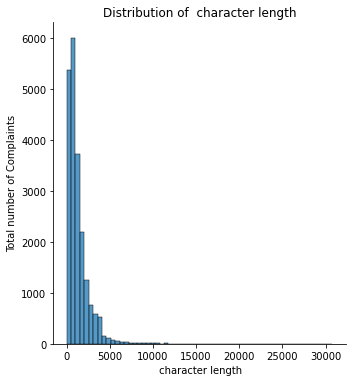

In [28]:
# Write your code here to visualise the data according to the 'Complaint' character length
char_len = [len(each_sent) for each_sent in df_clean['complaint_what_happened']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel(" character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of  character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

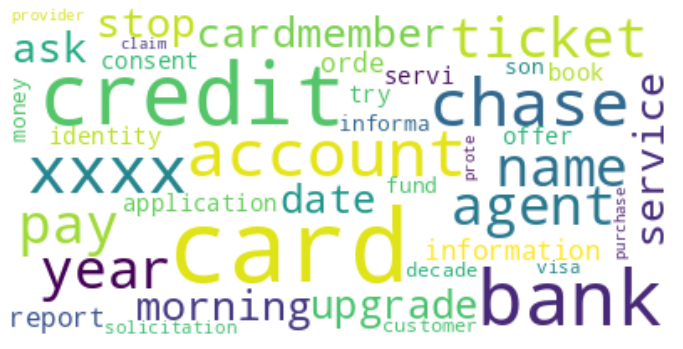

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [31]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [32]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [33]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])

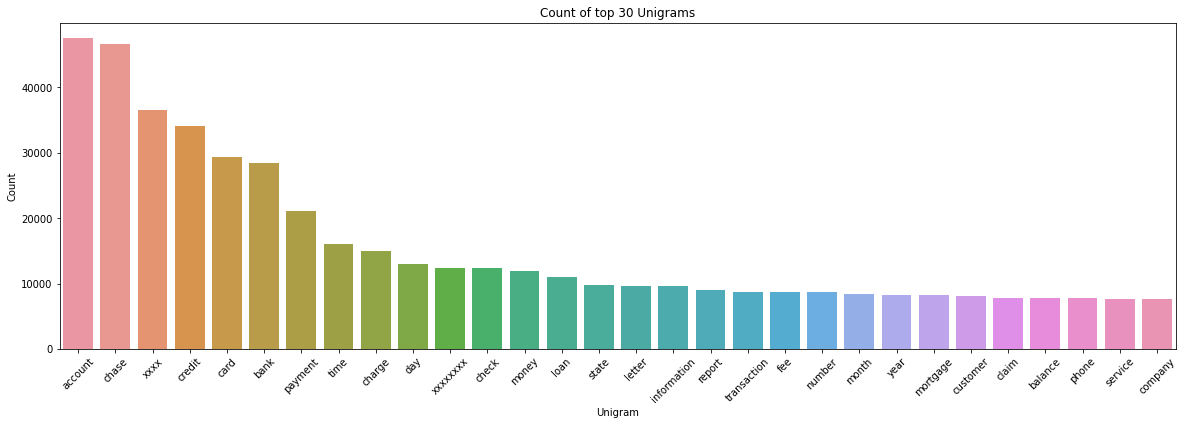

In [34]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [35]:
#Print the top 10 words in the unigram frequency
df_unigram[:10]

,unigram,count
0,account,47523
1,chase,46710
2,xxxx,36583
3,credit,34154
4,card,29289
5,bank,28410
6,payment,21170
7,time,16027
8,charge,15000
9,day,12977


In [36]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])

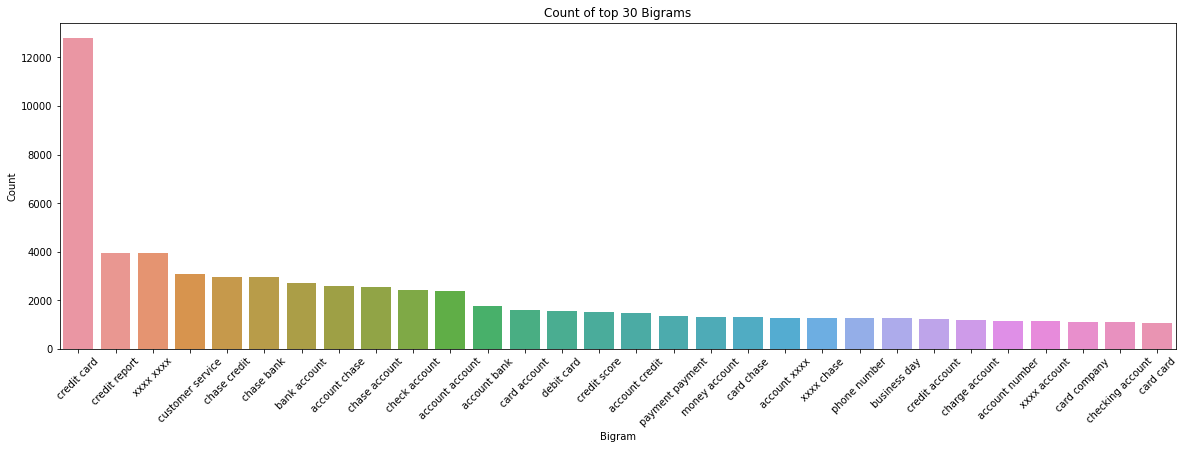

In [37]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [38]:
#Print the top 10 words in the bigram frequency
df_bigram[:10]

,bigram,count
0,credit card,12781
1,credit report,3955
2,xxxx xxxx,3951
3,customer service,3081
4,chase credit,2966
5,chase bank,2940
6,bank account,2728
7,account chase,2595
8,chase account,2564
9,check account,2413


In [39]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])

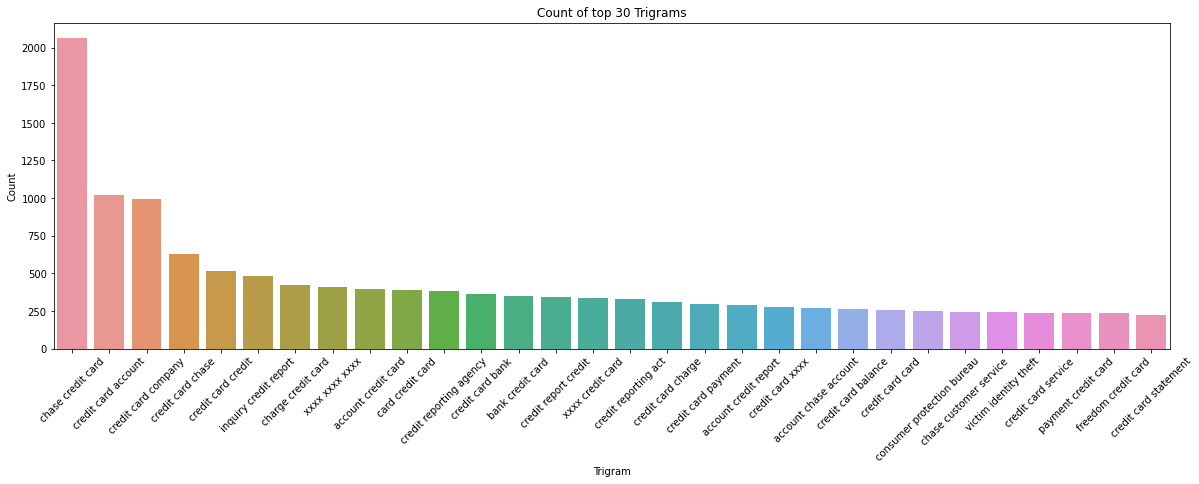

In [40]:
#Plotting top 30 trigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [41]:
#Print the top 10 words in the trigram frequency
df_trigram[:10]

,trigram,count
0,chase credit card,2063
1,credit card account,1023
2,credit card company,992
3,credit card chase,632
4,credit card credit,515
5,inquiry credit report,481
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [42]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [43]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [44]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [45]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [47]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [48]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

7267

In [49]:
#Print the Top15 words for each of the topics
H = nmf_model.components_ 
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


In [50]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [51]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_results.argmax(axis=1)

In [52]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [53]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [54]:
#df_clean[df_clean['Topic']==2]['Complaint_clean']
df_clean['complaint_what_happened'][21]

'on xxxx  i made a  payment to an online retailer using chase quick pay with xxxx on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank \n\ni contacted chase via a secured message on  explaining what happened and asked  is there a way to reverse this transaction or do you have a contact at xxxx that can give me more information about the recipient  that xxxx my message was reviewed and i received a response restating my original email and informing me that  the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team  i called the number listed in the emai

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [55]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:"Bank Account services", 1:"Credit card or prepaid card", 2:"Other", 3:"Theft/Dispute Reportings", 4:"Mortgage/Loan" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [56]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reportings
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reportings
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Other


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [57]:
#Create the dictionary again of Topic names and Topics
#Topic_names = { 0:"Bank Account services", 1:"Credit card or prepaid card", 2:"Other", 3:"Theft/Dispute Reportings", 4:"Mortgage/Loan" }
Topic_names = { "Bank Account services":0, "Credit card or prepaid card":1, "Other":2, "Theft/Dispute Reportings":3, "Mortgage/Loan":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [58]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,3
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,3
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,2


In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['Complaint_clean', 'Topic']]

In [60]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Complaint_clean  21072 non-null  object
 1   Topic            21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1009.9+ KB


In [61]:
y=pd.DataFrame(training_data['Topic'])

In [62]:
y.isnull().sum()

Topic    0
dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [63]:
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['Complaint_clean'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

In [64]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [65]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [66]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [67]:
X_train.shape, X_test.shape

((15804, 16339), (5268, 16339))

**Logistic regression**

In [68]:
# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [69]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [70]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.9523538344722855

**Decision Tree**

In [71]:
# Importing a DescisionTreeClassifier from sklearn
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 3).fit(X_train, y_train)

In [72]:
#Predictions
ydtree_train_pred = dtree_model.predict(X_train)
ydtree_test_pred = dtree_model.predict(X_test)

In [73]:
#Import the accuracy metrics
from sklearn.metrics import accuracy_score

In [75]:
print("Training Accuracy:",accuracy_score(y_train, ydtree_train_pred))
print("Testing Accuracy:",accuracy_score(y_test, ydtree_test_pred))

Training Accuracy: 0.6518602885345482
Testing Accuracy: 0.6552771450265755


**Decision Tree with Hyperparameter Tuning**

In [76]:
#Import Grid Search from sklearn
from sklearn.model_selection import GridSearchCV

In [77]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["gini", "entropy"]
}

In [79]:
# Create a model
dt_hpt = DecisionTreeClassifier(random_state=42)

In [80]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt_hpt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [81]:
#Fit the data
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50]},
             scoring='accuracy', verbose=1)

In [82]:
#Get the best estimater
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10,
                       random_state=42)

In [84]:
#Evaluate the model
dt_best = grid_search.best_estimator_
print("Training Accuracy:", accuracy_score(y_train, dt_best.predict(X_train)))
print("Testing Accuracy:", accuracy_score(y_test, dt_best.predict(X_test)))

Training Accuracy: 0.858327005821311
Testing Accuracy: 0.8168185269552012


**Random Forest**

In [85]:
#import Random Forest from sklearn
from sklearn.ensemble import RandomForestClassifier

In [87]:
#Instantiate the random forest model
rf = RandomForestClassifier(n_estimators=10, max_depth=4, max_features=5, random_state=100, oob_score=True)

In [88]:
#Train the model
rf.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:583: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



RandomForestClassifier(max_depth=4, max_features=5, n_estimators=10,
                       oob_score=True, random_state=100)

In [89]:
#Get the score
rf.oob_score_

0.2538597823335864

**Random Forest with Hyperparameter Tuning**

In [91]:
#Instantiate the model
rf_hpt = RandomForestClassifier(random_state=42, n_jobs=-1)

In [93]:
# Create the parameter grid based on the results of random forest 
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}

In [94]:
#Instantiate the Grid Search model
grid_search = GridSearchCV(estimator=rf_hpt,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

In [95]:
#Fit the data
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [96]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [97]:
#Get the best score
grid_search.best_score_

0.7706909643128322

**Naive Bayes**

In [98]:
#Import Gaussian NB from sklearn
from sklearn.naive_bayes import GaussianNB

In [102]:
#Train the model
gnb = GaussianNB().fit(X_train.toarray(), y_train)

In [104]:
#Get accuracy on test data
gnb.score(X_test.toarray(), y_test)

0.283788914198937

## Conclusion
    
* **We classified user complaints into below 5 topics:**
    1. Bank Account services
    2. Credit card or prepaid card
    3. Others
    4. Theft/Dispute Reporting
    5. Mortgage/Loan
    
    
* **We tried 4 models on the data with accuracies as follows:**

    1. Logistics Regression : 95%
    2. Decision Tree : 65%
    3. Decision Tree with Hyperparameter Tuning : 81%
    4. Random Forest : 25%
    5. Random Forest with Hyperparameter Tuning : 77%
    6. Naive Bayes : 28%

**Inference: Logistics Regression gives the best output The accuracy score is 95%. Therefore we will use this model to classify new customer complaint support ticket into its relevant department.**

In [106]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaint_what_happened': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaint_what_happened
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [112]:
#Define steps to predict topic for new data
def predict_lr(text):
    Topic_names = { 0:"Bank Account services", 1:"Credit card or prepaid card", 2:"Other", 3:"Theft/Dispute Reportings", 4:"Mortgage/Loan" }
    X_new_counts = vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = logreg.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [113]:
#Run the model for new data
df_complaints['tag'] = df_complaints['complaint_what_happened'].apply(lambda x: predict_lr([x]))
df_complaints

,complaint_what_happened,tag
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,"Yesterday, I received a fraudulent email regar...",Theft/Dispute Reportings
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,I need to know the number of bank branches and...,Bank Account services
